# Model training
Pytorch tutorial: [optimization_tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html)

## Prerequisite Code

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import os

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")

Using cuda device
num_workers = 12 cores


In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size=64
# train_dataloader = DataLoader(training_data, batch_size=batch_size,num_workers=num_workers)
# test_dataloader = DataLoader(test_data, batch_size=batch_size,num_workers=num_workers)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

100%|██████████| 26421880/26421880 [00:09<00:00, 2766824.34it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 157282.54it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2770706.32it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 37881187.71it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
im,label=training_data.__getitem__(0)
print(im.shape)
print(label)

torch.Size([1, 28, 28])
9


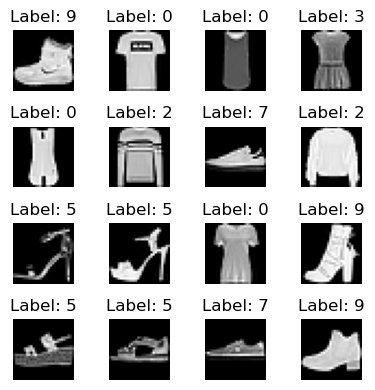

In [ ]:
# prompt: show 16 image from training_data using 4*4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(4, 4))
for i in range(16):
    row = i // 4
    col = i % 4
    im, label = training_data.__getitem__(i)
    axes[row, col].imshow(im.squeeze(), cmap='gray')
    axes[row, col].set_title(f"Label: {label}")
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3,padding=1),
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(8*7*7, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out

In [ ]:
model = CNNNetwork()
model.to(device)
print(model)

CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=392, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Hyperparameters

## Optimization Loop

In [ ]:
# Training loop (1 epoch)
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [ ]:
#Loss function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Epochs
epochs = 5

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.306730  [   64/60000]
loss: 0.755427  [ 6464/60000]
loss: 0.423886  [12864/60000]
loss: 0.557329  [19264/60000]
loss: 0.481985  [25664/60000]
loss: 0.563732  [32064/60000]
loss: 0.428174  [38464/60000]
loss: 0.599780  [44864/60000]
loss: 0.471807  [51264/60000]
loss: 0.407458  [57664/60000]
Test Error: 
 Accuracy: 84.6%, Avg loss: 0.413467 

Epoch 2
-------------------------------
loss: 0.275998  [   64/60000]
loss: 0.371938  [ 6464/60000]
loss: 0.243483  [12864/60000]
loss: 0.404208  [19264/60000]
loss: 0.379839  [25664/60000]
loss: 0.411449  [32064/60000]
loss: 0.300702  [38464/60000]
loss: 0.515330  [44864/60000]
loss: 0.392045  [51264/60000]
loss: 0.324904  [57664/60000]
Test Error: 
 Accuracy: 86.4%, Avg loss: 0.370442 

Epoch 3
-------------------------------
loss: 0.257586  [   64/60000]
loss: 0.311787  [ 6464/60000]
loss: 0.219769  [12864/60000]
loss: 0.340847  [19264/60000]
loss: 0.274936  [25664/60000]
loss: 0.372024  [32064/600

# Workshop13 image classification
data: [https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link](https://drive.google.com/file/d/1yCH8zIGo9KjdscRfrvpR1R7mel4uq1GH/view?usp=drive_link)

สร้างโมเดล และทำการฝึกโมเดลเพื่อทำนาย (วินิจฉัย) จากภาพเอกซเรย์ ฟร้อมวัดประสิทธิภาพ

(พิเศษ) เพิ่มการป้องกัน overfitting ด้วยเทคนิค early stopping โดยพิจารณาจาก validation loss หาก validation loss เพิ่มขึ้นเกินจำนวน epoch ที่กำหนดให้หยุดฝึกโมเดล

In [ ]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [ ]:
!unzip /content/Small_Data_CoV2.zip

Archive:  /content/Small_Data_CoV2.zip
   creating: Small_Data_CoV2_val/
   creating: Small_Data_CoV2_val/Covid/
   creating: Small_Data_CoV2_val/Covid/Patient (10)/
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132320.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132449.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132516.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132540.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132608.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132636.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132704.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132740.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-28 132814.png  
  inflating: Small_Data_CoV2_val/Covid/Patient (10)/Anota‡ֶo 2020-04-

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
train_img_dataset = ImageFolder('Small_Data_CoV2/Small_Data_CoV2_train', transform = train_transform)
test_img_dataset = ImageFolder('Small_Data_CoV2/Small_Data_CoV2_test', transform = test_transform)
val_img_dataset = ImageFolder('Small_Data_CoV2/Small_Data_CoV2_val', transform = test_transform)

In [ ]:
train_img_dataloader = DataLoader(train_img_dataset, batch_size = batch_size, shuffle = True)
test_img_dataloader = DataLoader(test_img_dataset, batch_size = batch_size, shuffle = False)
val_img_dataloader = DataLoader(val_img_dataset, batch_size = batch_size, shuffle = True)

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential( ## 224
            nn.Conv2d(3, 32,kernel_size=3,padding=1,stride=2), ## 112
            nn.ReLU(),
            nn.MaxPool2d(2), ## 56
            nn.Conv2d(32, 16, kernel_size=3,padding=1,stride=2), ## 28
            nn.ReLU(),
            nn.MaxPool2d(2), ## 14

        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(16*14*14, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        out = self.fc(x)
        return out



In [ ]:
# Training loop (1 epoch)
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


In [ ]:
# Testing loop
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

num_workers = os.cpu_count()
print(f"num_workers = {num_workers} cores")
model = CNNNetwork()
model.to(device)

Using cuda device
num_workers = 12 cores


CNNNetwork(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
#Loss function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Epochs
epochs = 20

In [ ]:
test_loss = 10e5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_img_dataloader, model, loss_fn, optimizer)
    test_loss_new = test_loop(test_img_dataloader, model, loss_fn)
    if test_loss_new >= test_loss*1.05:
        print("*"*25)
        print('Early Stopping')
        break
    test_loss = test_loss_new

print("Done!")

Epoch 1
-------------------------------
loss: 0.286259  [   64/  597]
Test Error: 
 Accuracy: 60.0%, Avg loss: 1.430555 

Epoch 2
-------------------------------
loss: 0.096179  [   64/  597]
Test Error: 
 Accuracy: 49.1%, Avg loss: 2.337846 

*************************
Early Stopping
Done!
